In [203]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import imageio
from IPython.display import Video
from typing import Sequence

import warnings
warnings.filterwarnings("ignore")

In [204]:
class MolecularDynamic:
    """
    the class to simulate Molecular Dynamic model
    """

    def __init__(self, N: int, vMax: float, sigma: float, epsilon: float, length: int) -> None:
        """
        the function to initialize the MD model

        :param N:the number of molecules
        :type N:int
        :param vMax:the maximum speed of the molecules
        :type vMax:float
        :param sigma:the distance param of the force
        :type sigma:float
        :param epsilon:the energy param of the force
        :type epsilon:float
        :param length:the size of the box
        :type length:int

        leftSideTrajectory is the trajectory of the number of molecules in the lft size of the box
        uTrajectory is the trajectory of the potential energy
        pressureTrajectory is the trajectory of the pressure
        xTrajectory is the trajectory of the position of the molecules
        vTrajectory is the trajectory of the velocity of the molecules
        tempTrajectory is the trajectory of the temperature of the system
        energyTrajectory is the trajectory of the energy
        rc is the threshold of the distance(we are gonna ignore further distances)
        a is the param for distance between molecules at the initial condition
        we set all of them at the left in a certain distance
        """

        self.rMag = None
        self.p = None
        self.filter = None
        self.leftSideTrajectory = None
        self.uTrajectory = None
        self.pressureTrajectory = None
        self.xTrajectory = None
        self.tempTrajectory = None
        self.vTrajectory = None
        self.energyTrajectory = None
        self.length = length
        self.N = N
        self.vMax = vMax
        self.epsilon = epsilon
        self.sigma = sigma
        self.rc = 2.5 * sigma
        self.distances = None


        a = int(1/(1/(2*N))**(1/2))
        # creating available positions based on a
        X = np.zeros((len( np.linspace(0,1,a+1)) * len(np.linspace(0,0.5,a//2)),2))
        for i,j in enumerate(itertools.product( np.linspace(0.1,0.9,a+1),np.linspace(0,0.5,a//2))):
            X[i] = j

        self.x = self.length * X[:N,0] +  self.length * X[:N,1]*1J#choosing the first N available position


        # randomly initializing velocities
        self.v = np.random.random((N,2))
        self.v -= np.mean(self.v , axis= 0 )
        self.v *= vMax

        self.v = self.v[:,0] + self.v[:,1]*1J


        self.T = self.getK()
        self.a = self.getAcceleration()




    def run(self, dt: float, bigSteps: int,smallSteps: int) -> None:
        """
        the function to go further in time for "steps" step of "dt"

        :param smallSteps: the big steps (getting data after each bigStep)
        :type smallSteps: int
        :param bigSteps: the small steps(total step of updating in bigStep)
        :type bigSteps:
        :param dt:the change of time in each step
        :type dt: float
        """

        #initializing the trajectories
        self.energyTrajectory = np.zeros(bigSteps)
        self.xTrajectory = np.zeros((bigSteps,self.N),dtype=np.complex128)
        self.vTrajectory = np.zeros((bigSteps,self.N),dtype=np.complex128)
        self.tempTrajectory = np.zeros(bigSteps)
        self.pressureTrajectory = np.zeros(bigSteps)
        self.uTrajectory = np.zeros(bigSteps)
        self.leftSideTrajectory = np.zeros(bigSteps)

        #main loop
        for i in range(bigSteps):
            print(i)  #to see the process is running

            for j in range(smallSteps):
                self.velocityVerlet(dt)

            #storing data
            self.xTrajectory[i]  = self.x
            self.vTrajectory[i]  = self.v
            self.T =  self.getK()
            self.tempTrajectory[i]  = self.T
            self.pressureTrajectory[i]  = self.p
            self.uTrajectory[i]  = self.getU()
            self.energyTrajectory[i] = self.tempTrajectory[i] + self.uTrajectory[i]
            self.leftSideTrajectory[i]  = self.getLeftSidedNum()


    def runScale(self, dt: float, bigSteps: int,smallSteps: int,scale:float) -> None:
        """
        the function to go further in time for "steps" step of "dt" and scale velocities after each big step

        :param scale: the param to scale the velocities
        :type scale: float
        :param smallSteps: the big steps (getting data after each bigStep)
        :type smallSteps: int
        :param bigSteps: the small steps(total step of updating in bigStep)
        :type bigSteps:
        :param dt:the change of time in each step
        :type dt: float
        """

        #initializing the trajectories
        self.energyTrajectory = np.zeros(bigSteps)
        self.xTrajectory = np.zeros((bigSteps,self.N),dtype=np.complex128)
        self.vTrajectory = np.zeros((bigSteps,self.N),dtype=np.complex128)
        self.tempTrajectory = np.zeros(bigSteps)
        self.pressureTrajectory = np.zeros(bigSteps)
        self.uTrajectory = np.zeros(bigSteps)
        self.leftSideTrajectory = np.zeros(bigSteps)

        #main loop
        for i in range(bigSteps):
            print(i)  #to see the process is running

            for j in range(smallSteps):
                self.velocityVerlet(dt)

            #storing data
            self.xTrajectory[i]  = self.x
            self.vTrajectory[i]  = self.v
            self.T =  self.getK()
            self.tempTrajectory[i]  = self.T
            self.pressureTrajectory[i]  = self.p
            self.uTrajectory[i]  = self.getU()
            self.energyTrajectory[i] = self.tempTrajectory[i] + self.uTrajectory[i]
            self.leftSideTrajectory[i]  = self.getLeftSidedNum()
            self.v *= scale


    def getLeftSidedNum(self) -> np.ndarray:
        """
        the function to get the number of molecules on the left side of the box

        :return: number of molecules on the left side of the box
        :rtype: np.ndarray
        """
        return np.sum(self.x.imag<=self.length/2)


    def getK(self) -> np.ndarray:
        """
        the function to get the kinetic energy of the system

        :return:the kinetic energy of the system
        :rtype: np.ndarray
        """
        return np.sum(np.square(self.v.real) + np.square(self.v.imag))/2

    def animate(self, trajectory: np.ndarray, name: str,jump) -> None:
        """
        the function to animate the trajectory of the system and save it as the name.

        :param jump: the interval
        :type jump: int
        :param trajectory:the input trajectory
        :type trajectory:np.ndarray
        :param name:the name ot save the video
        :type name: str
        """
        images = []
        for i in range(len(trajectory)//jump):
            plt.clf()
            plt.title("Animating md Model for bigSteps={0} size={1}".format(len(trajectory),self.length))
            plt.scatter(trajectory[i*jump,:].real,trajectory[i*jump,:].imag,c="blue",s=1)
            plt.xlim((0,self.length))
            plt.ylim((0,self.length))
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.savefig(str(i)+".png")
            images.append(imageio.imread(str(i)+".png"))

        imageio.mimsave('{}.mp4'.format(name), images)
        Video('{}.mp4'.format(name))


    def getCorrelationLength(self) -> Sequence:
        """
        the function to get the autoCorrelation for each particle and in each dimension and find the mean and finding the correlation length by fitting it into e^-1

        :return:autoCorrelations Array , the correlation length
        :rtype:
        """
        bigSteps = self.vTrajectory.shape[0]
        autoCorrelation = np.zeros(bigSteps)
        for j in np.arange(1,bigSteps):
            auto = 0
            for n in range(0,self.N):
                auto += self.getAutoCorrelation(self.vTrajectory[:,n].real,j)
                auto += self.getAutoCorrelation(self.vTrajectory[:,n].imag,j)

            autoCorrelation[j] = auto/(2*self.N)

        return (1+autoCorrelation),len((1+autoCorrelation)[(1+autoCorrelation) > np.exp(-1)])

    @staticmethod
    def getAutoCorrelation(Array: np.array, j: int) -> np.ndarray:
        """
        the function to get the autoCorrelation of the input array at j

        :param Array: the input array
        :type Array: np.array
        :param j: input place in array
        :type j: int
        :return: the autoCorrelation
        :rtype: np.ndarray
        """
        autoCor = np.mean(Array[:-j] * Array[j:]) - np.mean(Array[:-j] ** 2)
        autoCor /=  np.var(Array)
        return autoCor

    def getDistanceMatrix(self) -> np.ndarray:
        """
        the function to get the matrix of distances of particles by tiling up the positions and subtracting the positions from each other

        :return: the matrix of distances of particles
        :rtype: np.array
        """
        distances = np.zeros((1,self.N,self.N),dtype=complex)
        tiledPoses = np.tile(self.x, (self.N, 1))
        np.subtract(tiledPoses, np.transpose(tiledPoses), distances)

        self.distances = distances.reshape((self.N,self.N))
        # finding min distances
        self.distances = ((self.distances.real + self.length/2) % self.length - self.length/2) + 1J*((self.distances.imag+ self.length/2) % self.length - self.length/2)
        return self.distances


    def ljForce(self, r: np.ndarray) -> np.ndarray:
        """
        the function to calculate the force between two molecules

        :param r: the distance between two molecules
        :type r: np.ndarray
        :return: the force between two molecules
        :rtype: np.ndarray
        """


        self.rMag = np.sqrt(np.square(r.real) +  np.square(r.imag))  # magnitude of r
        self.filter = (self.rMag < self.rc)  #filtering the far particles
        self.filter = True

        fMag = -24 * self.epsilon * (2 * (self.sigma / self.rMag)**14 - (self.sigma / self.rMag)**8) * r # magnitude of force
        fMag = np.where(np.isnan(fMag),0,fMag)  # deleting the f where isnan for example rii = 0
        fMag *= self.filter



        #claculating pressure
        fDotR = np.sum(fMag.real * r.real + fMag.imag * r.imag)
        self.p = (self.N*self.T + fDotR) / (2*self.length**2)

        return fMag


    def getAcceleration(self) -> np.ndarray:
        """
        the function to get the acceleration by summation of the all forces applied on each particle

        :return: the acceleration array
        :rtype: np.array
        """
        return np.sum(self.ljForce(self.getDistanceMatrix()),axis=1)



    def velocityVerlet(self, dt: float) -> None:
        """
        the function to perform one update using velocity verlet algorithm

        :param dt:the change in time in the update
        :type dt: float
        """
        vNew = self.v + 0.5 * self.a * dt # update velocities
        xNew = (self.x + vNew * dt) # update positions
        self.x = self.getRebounded(xNew)


        aNew = self.getAcceleration()
        vNew = vNew + 0.5 * aNew * dt # update velocities

        self.v = vNew
        self.v -= np.mean(self.v)  # resetting Vcm
        self.a = aNew



    def getU(self) -> np.ndarray:
        """
        th function to calculate the total potential energy of the system

        :return: the total potential energy of the system
        :rtype: np.ndarray
        """
        Us = self.U(self.rMag)
        Us = np.where(np.isnan(Us),0,Us)  # ignoring where U explodes for example U(rii)
        return np.sum(Us*self.filter)/2


    def U(self, r: np.ndarray) -> np.ndarray:
        """
        the function to return the potential energy between to molecules based on lenard jones potential

        :param r:the distance between them
        :type r: np.ndarray
        :return: the potential energy
        :rtype: np.ndarray
        """
        return 4*self.epsilon*( (self.sigma/r)**12  - (self.sigma/r)**6)


    def getRebounded(self, xNew: np.ndarray) -> np.ndarray:
        """
        the function to rebound the positions using reminder of positions on length
        :param xNew: the unbounded positions
        :type xNew: np.array
        :return: rebounded positions
        :rtype: np.array
        """
        return (xNew.real % self.length) + (xNew.imag % self.length)*1J


## Main Part:(vMax =1)

In [205]:
md = MolecularDynamic(100,1,1,1,200)

In [206]:
bigSteps = 1000
smallSteps = 1000
h = 0.001

In [207]:
md.run(h,bigSteps,smallSteps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27


### part 0:

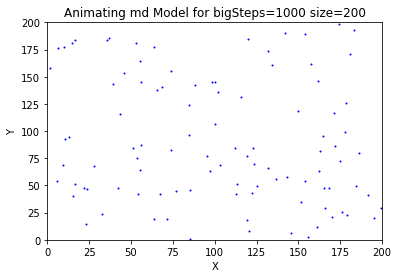

In [213]:
md.animate(md.xTrajectory,"part0_1",1)

### part 1:

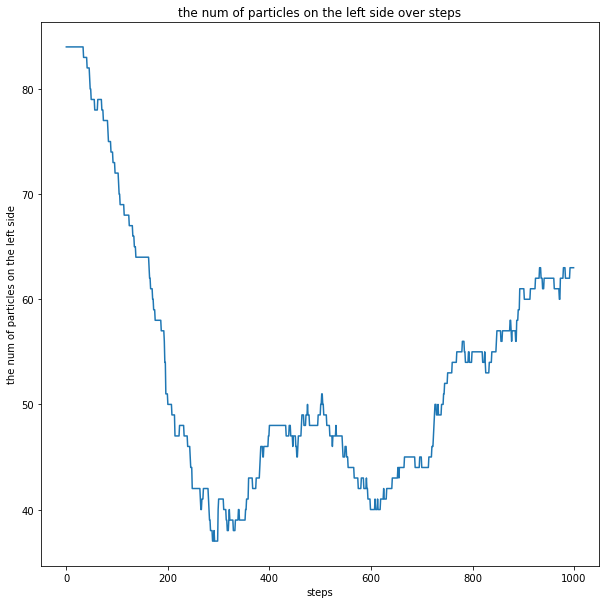

In [208]:
plt.figure(figsize=(10,10))
plt.title("the num of particles on the left side over steps")
plt.xlabel("steps")
plt.ylabel("the num of particles on the left side")
plt.plot(np.arange(bigSteps),md.leftSideTrajectory)
plt.show()

### part 2:

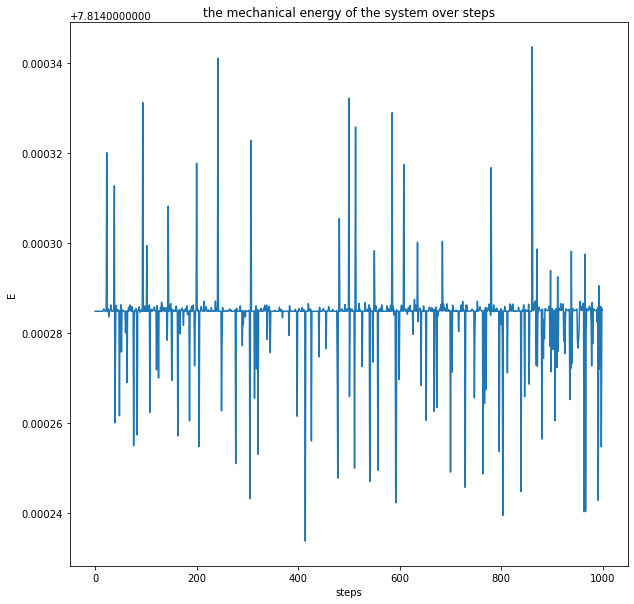

In [209]:
plt.figure(figsize=(10,10))
plt.title("the mechanical energy of the system over steps")
plt.xlabel("steps")
plt.ylabel("E")
plt.plot(np.arange(bigSteps),md.energyTrajectory)
plt.show()

### part 3:

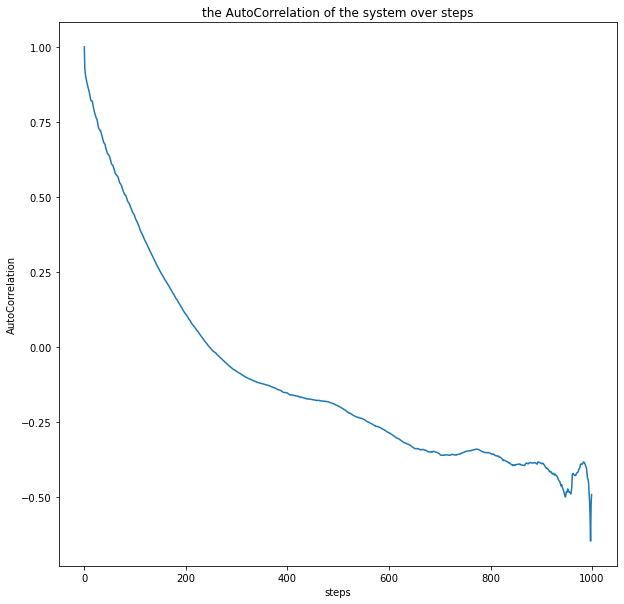

correlation length =117


In [210]:
plt.figure(figsize=(10,10))
plt.title("the AutoCorrelation of the system over steps")
plt.xlabel("steps")
plt.ylabel("AutoCorrelation")
md.getCorrelationLength()
auto , corrLength = md.getCorrelationLength()
plt.plot(np.arange(1000),auto[:1000])
plt.show()
print(f"correlation length ={corrLength}")

### part 4:

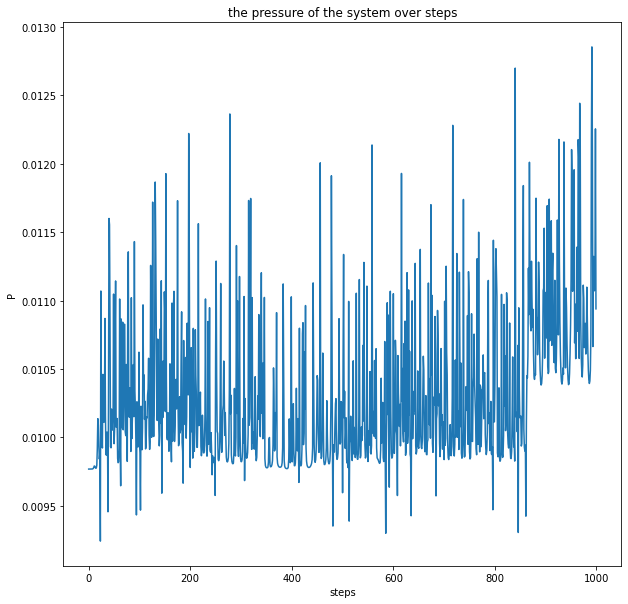

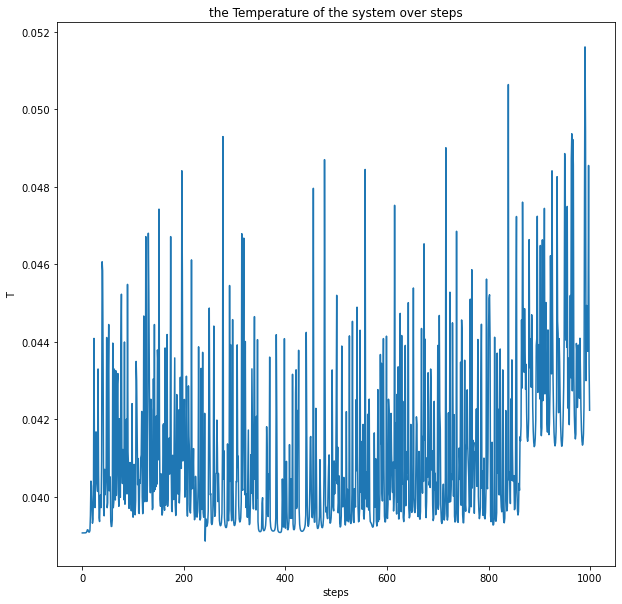

T =  0.04111958687100528
P =  0.010295963487762017


In [211]:
plt.figure(figsize=(10,10))
plt.title("the pressure of the system over steps")
plt.xlabel("steps")
plt.ylabel("P")
plt.plot(np.arange(bigSteps),md.pressureTrajectory[:bigSteps])
plt.show()

plt.figure(figsize=(10,10))
plt.title("the Temperature of the system over steps")
plt.xlabel("steps")
plt.ylabel("T")
plt.plot(np.arange(bigSteps),md.tempTrajectory[:bigSteps]/(2*md.N))
plt.show()

print("T = ",np.mean(md.tempTrajectory[:bigSteps])/(2*md.N))
print("P = ",np.mean(md.pressureTrajectory[:bigSteps]))

### part 5:

In [212]:
m,p0 = np.polyfit(md.tempTrajectory[:bigSteps],md.pressureTrajectory[:bigSteps]/(2*md.N),1)

a = - p0 * (md.length**2 / md.N) ** 2
b = (md.length**2 / md.N) - 1/(6.02 * 10**23)
print("a = {0} and b = {1}".format(a,b))

a = -4.974960016050408 and b = 400.0


## part 6:

In [192]:
md = MolecularDynamic(100,0.01,1,1,50)

In [193]:
bigSteps = 50
smallSteps = 10000
h = 0.01

### scaling velocities with 0.6 for 50 times

In [194]:
md.runScale(h,bigSteps,smallSteps,0.6)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49



### part 6:

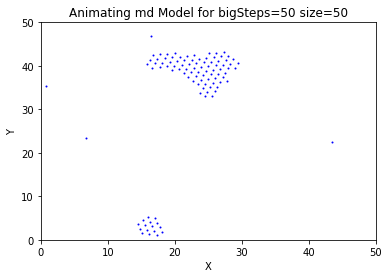

In [198]:
md.animate(md.xTrajectory,"part6",1)